The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
300000.0


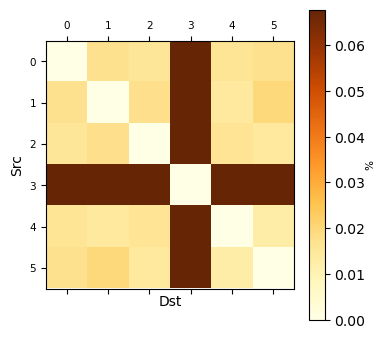

In [10]:
%load_ext autoreload
%autoreload

# %matplotlib ipympl

from trafpy.generator import Demand, DemandPlotter
import trafpy.generator as tpg
from trafpy.benchmarker import BenchmarkImporter

import time
import copy
from scipy.io import savemat

##################### SEED ##############################
import numpy as np
import random
from trafpy.utils import seed_stochastic_modules_globally
seed = 1
seed_stochastic_modules_globally(default_seed=0,
                                 numpy_module=np,
                                 random_module=random)
#########################################################

sid = 1
# set vars
# X = 4
# X = 2
X = 1
N = int(6*X)
# path = r'Y:/Joshua/Traffic/'
path = 'Y:/Joshua/Traffic/'
endpoints = [str(i) for i in range(N)]

# min_num_demands = 100
min_num_demands = N*N*100
min_last_demand_arrival_time = None
# loads = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
loads = [0.5]
# loads = [0.1]
# jensen_shannon_distance_threshold = 0.3
jensen_shannon_distance_threshold = 0.2
# jensen_shannon_distance_threshold = 0.1
NUM_DEMANDS_FACTOR = 5

sk_nd = [0, 0.25,0.5,0.75, 0.5625,0.8125,0.3125, 0.5625,0.8125]
sk_pr = [1, 0.64,0.64,0.64,0.16,0.16,0.32,0.32,0.32]

SN = sk_nd[sid-1]
SK = sk_pr[sid-1]
# num_skewed_nodes=int(len(endpoints)*SN)

# racks_dict = None
racks_dict, num_racks = {}, 4
eps_per_rack = int(N/num_racks)
for rack in range(num_racks):
    racks_dict[rack] = [ep for ep in range(rack*eps_per_rack, (rack*eps_per_rack)+eps_per_rack)]
# print(racks_dict)

# init network
# net = tpg.gen_arbitrary_network(ep_label=None, num_eps=N, ep_capacity=100000, racks_dict=racks_dict)
net = tpg.gen_arbitrary_network(ep_label=None, num_eps=N, ep_capacity=100000, racks_dict=None)
print(net.graph['max_nw_capacity'])

# # set flow size, interarrival time, and node distributions
# importer = BenchmarkImporter(benchmark_version='v001', load_prev_dists=False)
# benchmark_dists = importer.get_benchmark_dists(benchmark_name='university', eps=net.graph['endpoints'], racks_dict=net.graph['rack_to_ep_dict'])
# flow_size_dist, interarrival_time_dist, node_dist = benchmark_dists['flow_size_dist'], benchmark_dists['interarrival_time_dist'], benchmark_dists['node_dist']

# OPTIONAL HACK: Overwrite flow size dist so that can achieve prettier packed node dist plots after generating the traffic than when have heavy-tailed flow size dist (where get some node pairs becoming very 'hot' because they take one very large flow)

# flow_size_dist, _ = tpg.gen_named_val_dist(dist='weibull',
#                                            params={'_alpha': 4.8, '_lambda': 4100},
#                                            return_data=False,
#                                            show_fig=True,
#                                            round_to_nearest=1)

flow_size_dist = {25: 0.25, 50: 0.25, 75: 0.25, 100: 0.25}

interarrival_time_dist = {0.125:1}

# # node_dist = tpg.gen_uniform_node_dist(eps=net.graph['endpoints'],
# #                                          show_fig=False)    

# print(f'net.graph endpoint types: {type(net.graph["endpoints"][0])}')
# # raise Exception()
node_dist, _ = tpg.gen_multimodal_node_dist(eps=net.graph['endpoints'],
                                         skewed_nodes=[],
                                         skewed_node_probs=[SK/(SN*N) for _ in range(int(SN*N))],
                                         # show_fig=False,
                                         show_fig=True,
                                         plot_chord=False,
                                         num_skewed_nodes=int(SN*N))

Packing flows:   0%|          | 0/3600 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating load 0.5...
pair prob dict:
{'["0", "1"]': 0.017234843877488457, '["0", "2"]': 0.015463037497559735, '["0", "3"]': 0.06778533854675055, '["0", "4"]': 0.016107330726624725, '["0", "5"]': 0.017234843877488457, '["1", "2"]': 0.01755699049202095, '["1", "3"]': 0.06778533854675055, '["1", "4"]': 0.014496597653962252, '["1", "5"]': 0.019812016793748412, '["2", "3"]': 0.06778533854675055, '["2", "4"]': 0.016268404033890974, '["2", "5"]': 0.014335524346696004, '["3", "4"]': 0.06778533854675055, '["3", "5"]': 0.06778533854675055, '["4", "5"]': 0.012563717966767285, '["1", "0"]': 0.017234843877488457, '["2", "0"]': 0.015463037497559735, '["2", "1"]': 0.01755699049202095, '["3", "0"]': 0.06778533854675055, '["3", "1"]': 0.06778533854675055, '["3", "2"]': 0.06778533854675055, '["4", "0"]': 0.016107330726624725, '["4", "1"]': 0.014496597653962252, '["4", "2"]': 0.016268404033890974, '["4", "3"]': 0.06

Packed 3600 flows in 0.464 s | Node distribution Jensen Shannon distance from target achieved: 0.00904425796619164


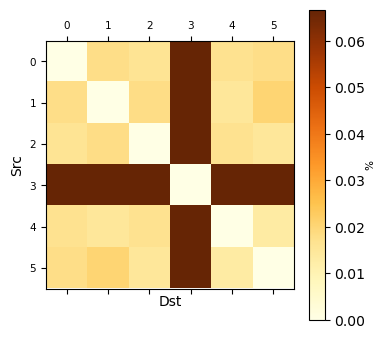

<Figure size 640x480 with 0 Axes>

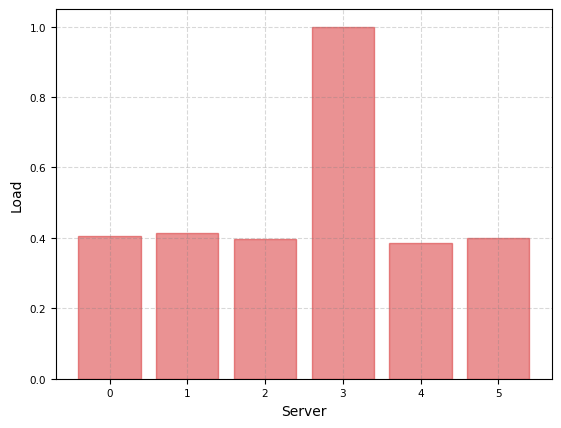

<Figure size 640x480 with 0 Axes>

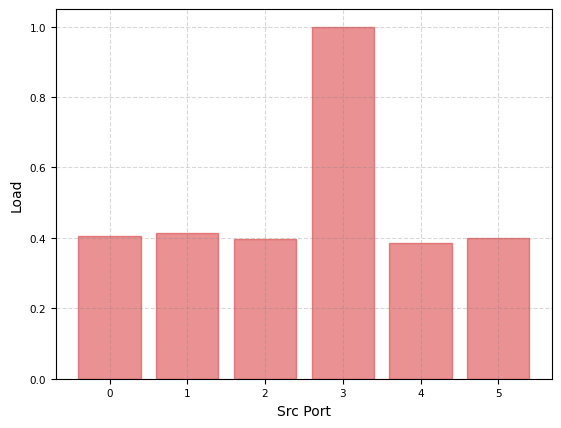

<Figure size 640x480 with 0 Axes>

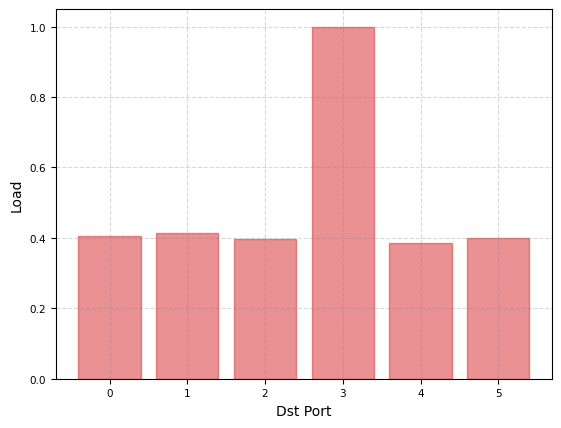

Generated load 0.5 in 1.560011863708496 seconds.


In [11]:
%load_ext autoreload
%autoreload


for load in loads:
    print('Generating load {}...'.format(load))
    
    start = time.time()
    
    network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                           'ep_link_capacity': net.graph['ep_link_capacity'],
                           'target_load_fraction': load}
    flow_centric_demand_data = tpg.create_demand_data(eps=net.graph['endpoints'],
                                                      node_dist=node_dist,
                                                      flow_size_dist=flow_size_dist,
                                                      interarrival_time_dist=interarrival_time_dist,
                                                      network_load_config=network_load_config,
                                                      jensen_shannon_distance_threshold=jensen_shannon_distance_threshold,
                                                      min_num_demands=min_num_demands,
                                                      min_last_demand_arrival_time=min_last_demand_arrival_time,
                                                      check_dont_exceed_one_ep_load=True,
                                                      auto_node_dist_correction=True,
                                                      print_data=True)

    demand = Demand(flow_centric_demand_data, net.graph['endpoints'])
    plotter = DemandPlotter(demand)
    plotter.plot_node_dist(eps=net.graph['endpoints'], plot_chord=False)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=net.graph['ep_link_capacity'])
    
    # save generated demands
    # savemat("custom/uniform/load{}_N{}_matlab_matrix.mat".format(load, N), flow_centric_demand_data)
    
    end = time.time()
    print('Generated load {} in {} seconds.'.format(load, end-start))

In [9]:
print(end-start)

0.6717584133148193
